### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import h5py
from tqdm import tqdm_notebook
import mahotas as mh
from IPython.display import display
from dual_IDG import DualImageDataGenerator

/home/artem/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [4]:
K.set_image_dim_ordering('th')

In [6]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [7]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [8]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [9]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
#h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [10]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Dropout(0.3)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [11]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 128, 128) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 9248        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [13]:
# Loading full images of desired resolution:
X = h5f['DRISHTI-GS/512 px/images']
Y = h5f['DRISHTI-GS/512 px/cup']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

In [14]:
X, Y

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">)

In [15]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = h5f['DRISHTI-GS/train_idx_cv'][0]
test_idx = h5f['DRISHTI-GS/test_idx_cv'][0]

In [16]:
print(len(X), len(train_idx), len(test_idx))
print(train_idx, test_idx)

(50, 40, 10)
(array([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 36, 37, 39, 41,
       42, 43, 44, 45, 47, 49]), array([ 2,  3, 27, 29, 31, 35, 38, 40, 46, 48]))


#### Generator of augmented data:

In [17]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=(0.8, 1.2),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()
#augm_idg = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
#                              horizontal_flip=True, vertical_flip=True,
#                              rotation_range=0.1, width_shift_range=0.1, height_shift_range=0.1,
#                              zoom_range=(1.0, 2.0),
#                              fill_mode='constant', cval=0.0)
# if using featurewise_center, featurewise_std_normalization or zca_whitening,
# augm_idg.fit(X_train, Y_train) is needed first

#### Preprocessing function and data generator:

In [18]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    # the following line thresholds segmentation mask for DRISHTI-GS, since it contains averaged soft maps:
    batch_y = batch_y >= 128
    # if line above is uncommented, division by 255.0 is not needed
    #batch_y = batch_y / 255.0
    
    if train_or_test == 'train':
        batch_X, batch_y = train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    elif train_or_test == 'test':
        batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, resize_to=128, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    """Gets random batch of data, 
    divides by 255,
    feeds it to DualImageDataGenerator."""
    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_X = [np.rollaxis(img, 2) for img in batch_X]
        batch_X = [sp.misc.imresize(img, (resize_to, resize_to)) for img in batch_X]
        batch_X = np.array(batch_X).copy()
        
        batch_y = [y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_y = [img[..., 0] for img in batch_y]
        batch_y = [sp.misc.imresize(img, (resize_to, resize_to))[..., None] for img in batch_y]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [20]:
gen = data_generator(X, Y, 128, 'train', batch_size=1)
batch = gen.next()
batch[0].shape

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/artem/.local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(1, 3, 128, 128)

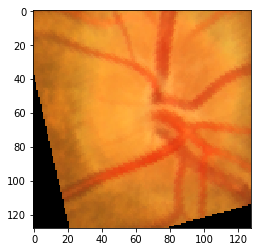

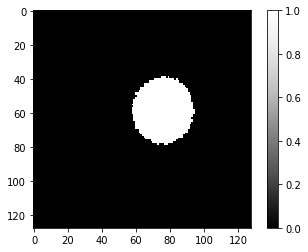

In [21]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

In [22]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"


weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))

In [23]:
weights_folder

'../models_weights/02.01,15:37,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/'

In [24]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


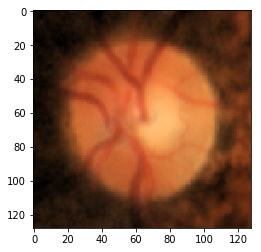

((10, 3, 128, 128), (10, 1, 128, 128))


In [26]:
X_valid, Y_valid = data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True).next()
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [ ]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              samples_per_epoch=len(train_idx),
                              max_q_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              nb_epoch=500, verbose=1,
                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv'), append=True),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=50),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

### Comprehensive visual check

In [29]:
# Function for rescaling cropped cup region and putting it back into original image,
# and resizing the result to resulting_size.
# Not needed if a model is trained on full (not cropped) images.

def rescale_back(cropped, rectangle, orig_size=(512, 512), resulting_size=(256, 256)):
    # `cropped` must be a grayscale image 
    # rectangle must be an iterable (min_i, min_j, max_i, max_j)
    
    min_i, min_j, max_i, max_j = rectangle
    part_rescaled = sp.misc.imresize(cropped, (max_i - min_i + 1, max_j - min_j + 1))
    resulting_img = np.zeros(orig_size, dtype=cropped.dtype)
    resulting_img[min_i:max_i + 1, min_j:max_j + 1] = part_rescaled
    resulting_img = sp.misc.imresize(resulting_img, resulting_size)
    return resulting_img

image #2


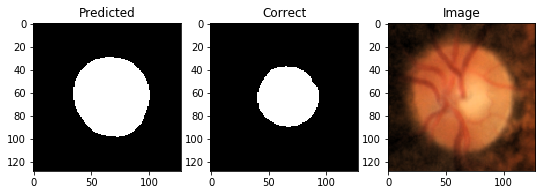

IOU: 0.602168500423
Dice: 0.751691827173
image #3


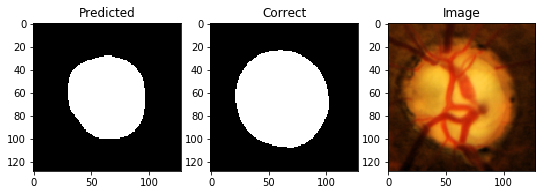

IOU: 0.72498601675
Dice: 0.840570317563
image #27


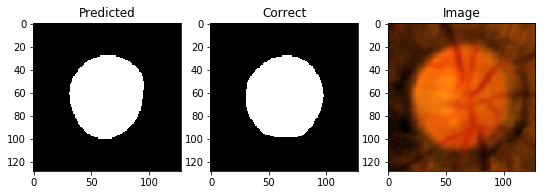

IOU: 0.932295739651
Dice: 0.964961739831
image #29


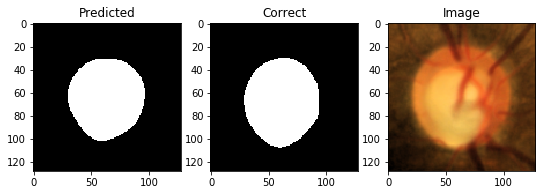

IOU: 0.881415069103
Dice: 0.936970338983
image #31


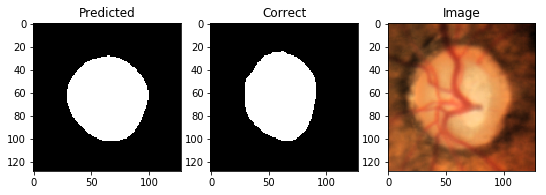

IOU: 0.856142878532
Dice: 0.922496749025
image #35


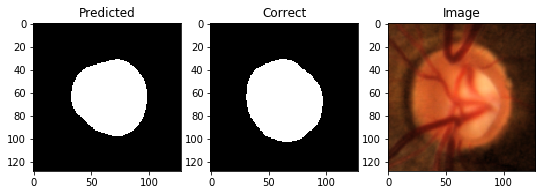

IOU: 0.828831195831
Dice: 0.906405340151
image #38


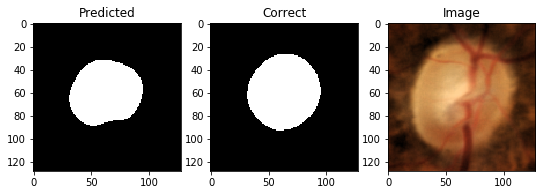

IOU: 0.847260475159
Dice: 0.917315658658
image #40


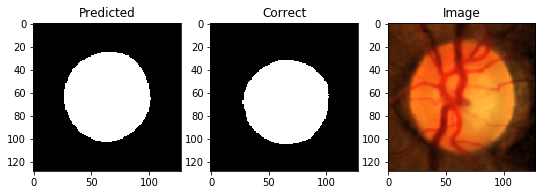

IOU: 0.838595032692
Dice: 0.912212872413
image #46


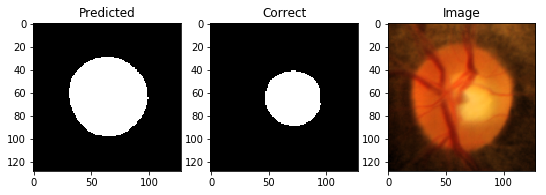

IOU: 0.495640337467
Dice: 0.662780105666
image #48


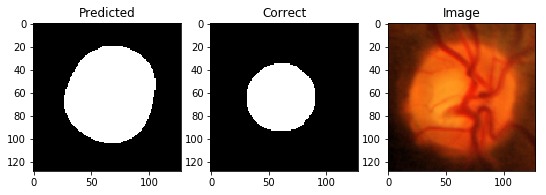

IOU: 0.532974421978
Dice: 0.695346795435


In [31]:
pred_iou, pred_dice = [], []

if K.backend() == 'tensorflow':
    sess = K.get_session()

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    if K.backend() == 'tensorflow':
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
    else:
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [32]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.754031
0.85107517449


### Loading model

In [28]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    # or get the most recent file in a folder:
    model_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights', '02.03,13_57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss')
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].argmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].argmax()])

('Loading weights from', '../models_weights/02.03,13_57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5')

max val mean IOU: 0.745275825262, at row:
epoch               495.000000
dice_metric           0.810811
loss                  0.163871
mean_IOU_gpu          0.695188
val_dice_metric       0.846246
val_loss              0.138325
val_mean_IOU_gpu      0.745276
Name: 495, dtype: float64

max val dice_metric: 0.84624595046, at row:
epoch               495.000000
dice_metric           0.810811
loss                  0.163871
mean_IOU_gpu          0.695188
val_dice_metric       0.846246
val_loss              0.138325
val_mean_IOU_gpu      0.745276
Name: 495, dtype: float64
